In [105]:
# %% Run this cell with ALT + SHIFT + ENTER
"""MuseScore3 Parser"""

###################
#Internal libraries
###################
import os, re, argparse, logging
from collections import defaultdict
from fractions import Fraction as frac


###################
#External libraries
###################
from bs4 import BeautifulSoup as bs         # python -m pip install beautifulsoup4
import pandas as pd
import numpy as np
import scipy
from scipy import stats
import matplotlib.pyplot as plt

In [3]:
###########
# Constants
###########
NEWEST_MUSESCORE = '3.2.3'

DURATIONS = {"measure" : 1.0,
             "breve"   : 2.0,
             "whole"   : 1.0,
             "half"    : frac(1/2),
             "quarter" : frac(1/4),
             "eighth"  : frac(1/8),
             "16th"    : frac(1/16),
             "32nd"    : frac(1/32),
             "64th"    : frac(1/64),
             "128th"   : frac(1/128)}

PITCH_NAMES = {0: 'F',
               1: 'C',
               2: 'G',
               3: 'D',
               4: 'A',
               5: 'E',
               6: 'B'}


# XML tags of MuseScore 3 format that this parser takes care of
TREATED_TAGS = ['accidental',   # within <KeySig>
                'Accidental',   # within <Note>, ignored
                'actualNotes',  # within <Tuplet>
                'Articulation', # optional
                'baseNote',     # within <Tuplet>, ignored
                'BarLine',
                'Chord',
                'dots',
                'durationType',
                'endRepeat',
                'endTuplet',
                'irregular',    # measure exluded from bar count
                'location',     # within <Volta>
                'Measure',
                'measures',     # within <next> within <Volta>
                'next',         # within <Volta>
                'noOffset',     # vlue to add to bar count from here on
                'normalNotes',  # within <Tuplet>
                'Note',         # within <Chord>
                'Number',       # within <Tuplet>, ignored
                'pitch',
                'prev',         # within <Volta>, ignored
                'Rest',
                'Slur',         # ignored
                'Spanner',      # several cases; used: "Tie" (test 8va)
                'startRepeat',
                'subtype',      # as part of <Articulation> or <BarLine>
                'TimeSig',
                'tpc',          # Tonal pitch class C = 0, F = -1, Bb = -2, G = 1,
                                # D = 2 etc. (i.e. MuseScore format minus 14: https://musescore.org/en/plugin-development/tonal-pitch-class-enum)
                'Tuplet',
                'voice',
                'Volta']

In [4]:
################################################################################
#                     HELPER FUNCTIONS in alphabetical order
################################################################################
def check_mn(mn_series):
    """Check measure numbers for gaps and overlaps."""
    # Check that numbers are strictly ascending
    ensure_ascending = mn_series < mn_series.shift()
    if ensure_ascending.any():
        ixs = mn_series.index[ensure_ascending]
        logging.error(f"Score contains descending barnumbers at measure count{'s ' if len(ixs) > 1 else ' '}{', '.join([str(i) for i in ixs])}, possibly caused by MuseScore's 'Add to bar number' function.")
    # Check for numbering gaps
    highest = mn_series.max()
    missing = [i for i in range(1, highest) if not i in mn_series.values]
    if len(missing) > 0:
        logging.error(f"The score has a numbering gap, these measure numbers are missing: {missing}")



def compute_mn(df, check=True):
    """Df with first column for excluded measures and facultative second column
       for offset ("add to bar count"); measure counts in the index.

    Example
    -------
        >>> df
        	dont_count	numbering_offset
        0	NaN	        NaN
        1	1	        NaN
        2	NaN	        NaN
        3	NaN	        -1
        4	NaN	        NaN
        >>> compute_mn(df)
        0    1
        1    1
        2    2
        3    2
        4    3
    """
    if df.__class__ == pd.core.series.Series:
        excluded = df
        offset = None
    else:
        excluded = df.iloc[:,0]
        offset   = df.iloc[:,1] if len(df.columns) > 1 else None

    ix = df.index
    regular_ix = ix[excluded.isna()]
    mn_in_score = pd.Series(range(1, 1 + len(regular_ix)), index=regular_ix)
    mn_in_score = mn_in_score.reindex(ix)
    if isnan(mn_in_score[0]):   # if anacrusis
        mn_in_score[0] = 0
    mn_in_score.fillna(method='ffill', inplace=True)
    if offset is not None and offset.notna().any():
        if isnan(offset[0]):
            offset[0] = 0
        offset = offset.fillna(method='ffill')
        mn_in_score += offset
    mn_in_score = mn_in_score.astype('int')
    if check:
        check_mn(mn_in_score)
    return mn_in_score



def convert_timesig(tag):
    """Turns a TimeSig-tag into a fraction. If you pass a list of tags, all need
    to represent the same time signature. In case of errors, None is returned.
    """
    if tag.__class__ == list:
        res = set([convert_timesig(t) for t in tag])
        if len(res) == 0:
            logging.error("List of timesignatures did not yield any result.")
            return None
        elif len(res) > 1:
            logging.error("List contains two different time signatures.")
            return None
        else:
            return res.pop()
    elif tag.name == 'TimeSig':
        N = tag.find('sigN')
        if N:
            N = N.string
        else:
            logging.error("TimeSig tag has no sigN tag.")
            return None
        D = tag.find('sigD')
        if D:
            D = D.string
        else:
            logging.error("TimeSig tag has no sigD tag.")
            return None

        return f"{N}/{D}"



def feature_from_node(tag, nodes):
    """Gets a tag name and a list of corresponding tags and
    computes a useful value from it."""
    if len(nodes) == 0:
        logging.error("Got empty node list. This shouldn't have happened:\
                        check construction of defaultdict 'infos' in function\
                        get_measure_infos")
        return None
    if len(nodes) > 1 and tag != 'voice':
        logging.warning(f"{len(nodes)} {tag}-nodes in one <Measure>.")

    if tag == 'voice':
        return len(nodes)
    else:
        node = nodes[0]

    if tag in ['accidental', 'noOffset', 'irregular']:
        try:
            return int(node.string)
        except:
            print(node)
    elif tag == 'TimeSig':
        return convert_timesig(node)
    elif tag in ['endRepeat', 'startRepeat']:
        return tag
    elif tag == 'Volta':
        return int(node.find_next('next').location.measures.string)
    elif tag == 'BarLine':
        subtype = node.find('subtype')
        return subtype.string if subtype else 'other'
    else:
        logging.error(f"Treatment of {tag}-tags not implemented.")


def get_repeat_structure(tag_series):
    """Accepts a Series of start tags ('firstMeasure', 'startRepeat') and end tags
    ('endRepeat', 'lastMeasure'), checks for correct structure and returns repeated
    sections based on the index values.

    Example
    -------
        >>> tag_series
        0     firstMeasure
        8        endRepeat
        9      startRepeat
        14       endRepeat
        21     startRepeat
        24       endRepeat
        40     lastMeasure
        Name: repeats, dtype: object
        >>> get_repeat_structure(tag_series)
        [(0, 8), (9, 14), (21, 24)]
    """
    OK=True
    tag_series = tag_series.dropna()
    tag_series.sort_index(inplace=True)
    stack, repeat_structure = [], []
    for i, tag in tag_series.iteritems():

        if tag == 'firstMeasure':
            if i != 0:
                logging.error("A 'firstMeasure' tag occurred somewhere after the first measure.")
                OK = False
            # firstMeasure serves as startRepeat if the next element is an endRepeat.
            elif tag_series.iloc[1] == 'endRepeat':
                stack.append((0,))
                logging.debug("First measure used as startRepeat because next tag is endRepeat.")
            else:
                logging.debug(f"First measure not used as startRepeat because tag element is {tag_series.iloc[1]}")

        elif tag == 'startRepeat':
            stack.append((i,))

        elif tag == 'endRepeat':
            if len(stack) > 0:
                section_start = stack.pop(-1)
                repeat_structure.append(section_start + (i,))
            else:
                correct = '\n'.join(tag_series[:i]) + '\n'
                logging.error(f"Correct up to {correct}Next {tag} invalid.")
                OK = False
                return repeat_structure

        elif tag == 'lastMeasure':
            if len(stack) > 0:
                logging.warning("A startRepeat still needs closing. Assuming that the last measure closes it.")
                OK = False
                section_start = stack.pop(-1)
                repeat_structure.append(section_start + (i,))

        else:
            logging.warning(f"{tag}-tag has been ignored by get_repeat_structure().")
            OK = False

    if len(stack) > 0:
        logging.error("A startRepeat still needs closing.")
        OK = False
        repeat_structure.append(stack[-1])
        return repeat_structure
    else:
        if OK:
            logging.debug("Repeat structure OK.")
        return repeat_structure



def get_volta_structure(df):
    OK = True
    repeats = df.repeats
    voltas = df.volta.dropna()
    volta_structure = []
    nxt = -1
    for i, length in voltas.iteritems():
        volta_range = list(range(i, i + int(length)))
        if i != nxt:    # new volta group
            volta_structure.append([volta_range])
        else:           # extend volta group
            volta_structure[-1].append(volta_range)
        nxt = i+length
        if 'startRepeat' in repeats.loc[volta_range,].values:
            logging.error(f"Volta with range {volta_range} contains startRepeat!")
            OK = False

    # Check if voltas in same group have the same length
    for group in volta_structure:
        I = iter(group)
        l = len(next(I))
        if not all(len(volta_range) == l for volta_range in I):
            logging.warning(f"Volta group has voltas with different lengths: {group}")
            OK = False

    if OK:
        logging.debug("Volta structure OK.")
    return volta_structure



def isnan(num):
    """Return True if `num` is np.NaN (not a number)"""
    return num != num


def nan_eq(a, b):
    """Check for equality, including NaNs"""
    if a.__class__ == pd.core.series.Series:
        assert b.__class__ == pd.core.series.Series, f"If a is a Series, b should not be a {type(b)}"
        return (a == b) | ((a != a) & (b != b))
    return a == b or (isnan(a) and isnan(b))



def midi2octave(val):
    """Sets midi notes 60-71 to octave 4"""
    return val // 12 - 1


def search_in_list_of_tuples(L, pos, search, add=0):
    """ Returns a list of indices.

    Parameters
    ----------
    L : :obj:`list` of :obj:`tuple`
        List of tuples in which you want elements with value `search`.
    pos : :obj:`int`
        In which position of the tuples to search.
    search : :obj:`object`
        What to look for.
    add : :obj:`int`, opt
        How much you want to add to each index value.
    """
    return [i+add for i, item in enumerate(L) if item[pos] == search]



def sort_dict(D):
    """ Returns a new dictionary with sorted keys. """
    return {k: D[k] for k in sorted(D)}



def spell_tpc(tpc):
    """Return name of a tonal pitch class where
       0 = C, -1 = F, -2 = Bb, 1 = G etc.
    """
    if tpc.__class__ == pd.core.series.Series:
        return tpc.apply(spell_tpc)

    tpc += 1 # to make the lowest name F = 0 instead of -1
    if tpc < 0:
        acc = abs(tpc // 7) * 'b'
    else:
        acc = tpc // 7 * '#'
    return PITCH_NAMES[tpc % 7] + acc

In [5]:
################################################################################
#                             SECTION CLASS
################################################################################
class Section(object):
    """ Holds the properties of a section.

    Attributes
    ----------
    first_mc, last_mc : :obj:`int`
        Measure counts of the section's first and last measure nodes.
    first_mn, last_mn : :obj:`int`
        First and last measure number as shown in the score.
    start_break, end_break : :obj:`str`
        What causes the section breaks at either side.
    index : :obj:`int`
        Index (running number) of this section.
    notes : :obj:`pandas.DataFrame`
        DataFrame holding all notes and their features.
    parent : :obj:`Score`
        The parent `Score` object that is creating this section.
    previous_section, next_section : :obj:`int`
        Indices of the previous and following sections in the score.
    repeated : :obj:`bool`
        Whether or not this section is repeated.
    subsection_of : :obj:`int`
        If section is a subsection, the index of the super_section, None otherwise.
    voltas : :obj:`list` of :obj:`range`
        Ranges of voltas. Default: empty list
    """

    def __init__(self, parent, first_mc, last_mc, index, repeated, start_break, end_break, voltas=[]):
        self.first_mc, self.last_mc = first_mc, last_mc
        self.first_mn, self.last_mn = None, None
        self.index = index
        self.repeated = repeated
        self.start_break, self.end_break = start_break, end_break
        self.voltas = [] if voltas is None else voltas
        self.subsection_of = None
        features = ['mc', 'onset', 'duration', 'nominal_duration', 'scalar', 'tied', 'tpc', 'midi', 'staff', 'voice', 'volta']
        for f in ['articulation']:
            if f in parent.score_features:
                features.append(f)
        self.notes = pd.DataFrame(columns=features)
        if index > 0:
            self.previous_section = index-1
            parent.sections[index-1].next_section = index
        else:
            self.previous_section = None
        self.next_section = None

        #######################
        # THINK ABOUT WHAT TO DO IMMEDIATELY AND WHAT TO DO IN POSTPROCESSING!
        #######################

        # Parse all measures contained in this section
        volta_dict = {mc: volta+1 for volta, measures in enumerate(self.voltas) for mc in measures}
        df_vals = {col: [] for col in self.notes.columns}
        for mc, measure_stack in enumerate(zip(*[[measure for mc, measure in node_dicts.items() if self.first_mc <= mc <= self.last_mc] for node_dicts in parent.measure_nodes.values()])):
            mc += self.first_mc
            nodetypes = defaultdict(list)
            mc_info = parent.mc_info[0].loc[mc]
            for staff_id, measure in enumerate(measure_stack):
                staff_id += 1
                for tag in measure.find_all(recursive=False):
                    nodetypes[tag.name].append(tag)
                tagtypes = set()
                if 'voice' in nodetypes:
                    # Parse all events within a voice within a measure within a staff
                    for voice, voice_tag in enumerate(nodetypes['voice']):
                        voice += 1
                        pointer = frac(0)
                        scalar = 1
                        scalar_stack = []
                        for event in voice_tag.find_all(['Chord', 'Rest', 'Tuplet', 'endTuplet']):
                            for tag in event.find_all(recursive=True):
                                tagtypes.add(tag.name)
                            if event.name == 'Tuplet':
                                scalar_stack.append(scalar)
                                scalar = scalar * frac(int(event.normalNotes.string), int(event.actualNotes.string))
                            elif event.name == 'endTuplet':
                                scalar = scalar_stack.pop()
                            else:
                                nominal_duration = DURATIONS[event.find('durationType').string]
                                dots = event.find('dots')
                                dotscale = sum([frac(1/2) ** i for i in range(int(dots.string)+1)]) * scalar if dots else scalar
                                duration = nominal_duration * dotscale
                                if event.name == 'Chord':

                                    if 'articulation' in parent.score_features and event.find('Articulation'):
                                        articulation = event.Articulation.subtype.string
                                    else:
                                        articulation = np.nan

                                    for note in event.find_all('Note'):

                                        def get_feature_value(f):
                                            if   f == 'mc':
                                                return mc
                                            elif f == 'staff':
                                                return staff_id
                                            elif f == 'voice':
                                                return voice
                                            elif f == 'onset':
                                                return pointer
                                            elif f == 'duration':
                                                return duration
                                            elif f == 'nominal_duration':
                                                return nominal_duration
                                            elif f == 'scalar':
                                                return dotscale
                                            elif f == 'tpc':
                                                return int(note.tpc.string) - 14
                                            elif f == 'midi':
                                                return int(note.pitch.string)
                                            elif f == 'volta':
                                                return volta_dict[mc] if mc in volta_dict else np.nan
                                            elif f == 'articulation':
                                                return articulation
                                            elif f == 'tied':
                                                tie = note.find('Spanner', {'type': 'Tie'})
                                                if tie:                                 # -1: end of tie
                                                    t = -1 if tie.find('prev') else 0   #  1: beginning of tie
                                                    t += 1 if tie.find('next') else 0   #  0: both
                                                else:
                                                    t = np.nan
                                                return t

                                        for f in features:
                                            df_vals[f].append(get_feature_value(f))



                                pointer += duration


                    del nodetypes['voice']


                else:
                    logging.error('Measure without <voice> tag.')

                global TREATED_TAGS
                remaining_tags = [k for k in list(tagtypes) + list(nodetypes.keys()) if not k in TREATED_TAGS]
                if len(remaining_tags) > 0:
                    logging.debug(f"The following tags have not been treated: {remaining_tags}")

        df = pd.DataFrame(df_vals).astype({'volta': 'Int64', 'tied': 'Int64'})
        df = df.groupby('mc', group_keys=False).apply(lambda df: df.sort_values(['onset', 'midi']))
        self.notes = df.reset_index(drop=True)

    def __repr__(self):
        return f"{'Repeated s' if self.repeated else 'S'}{'' if self.subsection_of is None else 'ubs'}ection from node {self.first_mc} ({self.start_break}) to node {self.last_mc} ({self.end_break}), {'with ' + str(len(self.voltas)) if len(self.voltas) > 0 else 'without'} voltas."

In [6]:
################################################################################
#                             SCORE CLASS
################################################################################
class Score(object):
    """ Parser for MuseScore3 MSCX files.

    NOTE: Measure count ``mc`` refers to the `mc` th measure node, whereas measure
    number ``mn`` refers to the `mn` th measure in the score. The latter can consist
    of several measure nodes and can be split across sections.

    Attributes
    ----------
    dir : :obj:`str`
        Directory where the parsed file is stored.
    file : :obj:`str`
        Absolute or relative path to the MSCX file you want to parse.
    filename : :obj:`str`
        Filename of the parsed file.
    last_node : :obj:`int`
        Count of the score's last measure node.
    mc_info : :obj:`dict` of :obj:`pandas.DataFrame`
        One DataFrame per staff where measure counts are index values and columns
        hold corresponding structural information.
    measure_nodes : :obj:`dict` of :obj:`dict` of :class:`bs4.element.Tag`
        Keys of the first dict are staff IDs, keys of each inner dict are incremental
        measure counts (NOT measure numbers) and values are XML nodes.
    score : :class:`bs4.BeautifulSoup`
        The complete XML structure of the parsed MSCX file.
    score_features : :obj:`list` of {'articulation'}
        Additional features you want to extract.
    section_breaks : :obj:`dict`
        Keys are the counts of the measures that have a section break, values are
        lists of the breaking elements {startRepeat, endRepeat, BarLine}
    section_order : :obj:`list` of :obj:`int`:
        List of section IDs representing in which the sections in ``section_structure``
        are presented and repeated.
    section_structure : :obj:`list` of :obj:`tuple` of :obj:`int`
        Keys are section IDs, values are a tuple of two measure counts, the
        (inclusive) boundaries of the section. That is to say, no measure count
        can appear in two different value tuples since every measure can be part
        of only one section.
    sections : :obj:`dict` of :obj:`Section`
        The sections of this score.
    separating_barlines : :obj:`list` of :obj:`str`
        List of barline types that cause the score to be split in separate sections.
    staff_nodes : :obj:`dict` of :class:`bs4.element.Tag`
        Keys are staff IDs starting with 1, values are XML nodes.
    super_sections : :obj:`dict` of :obj:`list`
        This dictionary has augmenting keys standing for one of the super_sections,
        i.e. sections that are grouped in the score by an englobing repetition,
        represented by lists of section IDs.
    super_section_order : :obj:`list` of :obj:`int`
        A more abstract version of section_order, using the keys from super_sections.
    """

    def __init__(self, file, score_features=[], separating_barlines=['double']):

        # Initialize attributes
        self.file = file
        self.dir, self.filename = os.path.split(os.path.abspath(file))
        self.staff_nodes = {}
        self.measure_nodes = {}
        self.score_features = score_features
        self.section_breaks = defaultdict(list)
        self.sections = {}
        self.section_structure = {}
        self.section_order = []
        self.separating_barlines = separating_barlines
        self.super_sections = {}
        self.super_section_order = []
        self.mc_info = {}

        # Load file
        with open(self.file, 'r') as file:
            self.score = bs(file.read(), 'xml')

        # Check Musescore version
        ms_version = self.score.find('programVersion').string
        if ms_version != NEWEST_MUSESCORE:
            logging.warning(f"{self.filename} was created with MuseScore {ms_version}. Auto-conversion will be implemented in the future.")
        assert ms_version.split('.')[0] == '3', f"This is a MS2 file, version {ms_version}"
        # ToDo: Auto-conversion

        #######################################################################
        # Store basic HTML nodes for quick access and extract structural info #
        #######################################################################

        # Extract staves
        for staff in self.score.find('Part').find_next_siblings('Staff'):
            staff_id = int(staff['id'])
            self.staff_nodes[staff_id] = staff
            self.measure_nodes[staff_id] = {}
            logging.debug(f"Stored staff with ID {staff_id}.")

        # Extract measures
        tag_to_col = {'accidental': 'keysig',
                      'TimeSig': 'timesig',
                      'voice': 'voices',
                      'startRepeat': 'repeats',
                      'endRepeat': 'repeats',
                      'Volta': 'volta',
                      'BarLine': 'barline',
                      'noOffset': 'numbering_offset',
                      'irregular': 'dont_count'
                      }

        cols = ['keysig', 'timesig', 'act_dur', 'voices', 'repeats', 'volta', 'barline', 'numbering_offset', 'dont_count']

        def get_measure_infos(measure):
            """Treat <Measure> node and return info dict."""
            mc_info = {}
            if measure.has_attr('len'):
                mc_info['act_dur'] = frac(measure['len'])
            infos = defaultdict(list)
            for tag in measure.find_all(tag_to_col.keys()):
                infos[tag.name].append(tag)
            for tag, nodes in infos.items():
                col = tag_to_col[tag]
                mc_info[col] = feature_from_node(tag, nodes)
            return mc_info


        for staff_id, staff in self.staff_nodes.items():
            mc_info = pd.DataFrame(columns=cols)

            for i, measure in enumerate(staff.find_all('Measure')):
                self.measure_nodes[staff_id][i] = measure
                logging.debug(f"Stored the {i}th measure of staff {staff_id}.")

                mc_info = mc_info.append(get_measure_infos(measure), ignore_index=True)

            self.mc_info[staff_id] = mc_info

        # all staves should have the same number of measures
        mcs = set(len(df.index) for df in self.mc_info.values())
        if len(mcs) > 1:
            logging.error("Staves have different measure counts. Check DataFrames in self.mc_info")

        # Last measure count
        self.last_node =  max(self.mc_info[1].index)

        # Check for infos which are not included in self.mc_info[1]; i.e.,
        # infos appearing only in one of the lower staves.
        for col in self.mc_info[1].columns:
            if not col in ['voices']:    # Exclude columns, that will be aggregated anyway
                cols = [self.mc_info[k][col] for k in self.mc_info.keys()]
                c1 = cols[0]
                cols = cols[1:]
                for i, c in enumerate(cols):
                    if not c1.equals(c):
                        not_in_c1 = c[~nan_eq(c1, c)]
                        if len(not_in_c1.dropna()) > 0:
                            logging.warning(f"These values in mc_info[{i+2}] are not included in mc_info[1]: {not_in_c1}")

        # complete the keysig and timesig infos
        for staff, mc_info in self.mc_info.items():
            first_row = mc_info.iloc[0]
            last_row = mc_info.iloc[-1]
            if isnan(first_row.keysig):
                first_row.keysig = 0
                logging.debug("Key signature has been set to C major.")
            if isnan(first_row.timesig):
                logging.error(f"Time signature not defined in the first measure of staff {staff}.")
            if not isnan(first_row.repeats):
                logging.warning(f"First measure of staff {staff} has a {first_row.repeats} tag. Information overwritten by 'firstMeasure'")
            mc_info.loc[0, 'repeats'] = 'firstMeasure'
            if isnan(last_row.repeats):
                mc_info.loc[last_row.name, 'repeats'] = 'lastMeasure'
            mc_info[['keysig', 'timesig']] = mc_info[['keysig', 'timesig']].fillna(method='ffill')

        #######################################################################
        # Create the master DataFrame mc_info[0], combining all staves'       #
        # structural information and newly computed infos such as bar numbers #
        #######################################################################

        self.mc_info[0] = self.mc_info[1].copy()
        for df in (self.mc_info[k] for k in self.mc_info.keys() if k > 1):
            self.mc_info[0].fillna(df, inplace=True)
        same = self.mc_info[0].equals(self.mc_info[1])
        if same:
            logging.debug(f"mc_info[0] and mc_info[1] were identical before aggregation.")
        else:
            logging.warning(f"mc_info[0] and mc_info[1] were not identical before aggregation.\
                            This means that lower staves contain information that's missing in\
                            the first staff (as shown in previous warning).")
        # Aggregate values in self.mc_info[0]
        for df in (self.mc_info[k] for k in self.mc_info.keys() if k > 1):
            self.mc_info[0].voices += df.voices


        #############################
        # Compute section structure #
        #############################
        repeat_structure = get_repeat_structure(self.mc_info[0].repeats)
        volta_structure = get_volta_structure(self.mc_info[0])
        # extending repeated sections that have voltas
        volta_dict = defaultdict(lambda: None)



        for group in volta_structure:
            for i, volta in enumerate(group):
                self.mc_info[0].loc[volta, 'volta'] = i+1
            endRepeat = group[0][-1] # last mc of the first volta
            ixs = search_in_list_of_tuples(repeat_structure, 1, endRepeat)
            if len(ixs) == 1:
                fro, to = repeat_structure[ixs[0]]
                measures_in_group = [item for nextvolta in group[1:] for item in nextvolta]
                if len(measures_in_group) > 0:
                    newto = max(measures_in_group)
                    repeat_structure[ixs[0]] = (fro, newto)
                    volta_dict[(fro, newto)] = group
                else:
                    logging.error(f"Volta group {group} does not seem to have more than one volta. Section {(fro, to)} keeps its length.")
            else:
                logging.error(f"The last measure {endRepeat} of this group's first volta: {group} does not contain an endRepeat sign (or repeat_structure has been incorrectly computed).")


        def create_section(fro, to, repeated=False, volta_group=None):
            nonlocal section_counter, super_counter
            start_reason = 'start' if isnan(self.mc_info[0].repeats[fro]) else self.mc_info[0].repeats[fro]
            end_reason   = 'end'   if isnan(self.mc_info[0].repeats[to])  else self.mc_info[0].repeats[to]
            if start_reason == 'start':
                start_reason = 'startRepeat' if repeated else 'startNormal'
            if end_reason == 'end':
                end_reason = 'endRepeat' if repeated else 'endNormal'

            inner_structure = self.mc_info[0].loc[fro+1:to]
            splits = inner_structure.barline.isin(self.separating_barlines)
            if splits.any(): # check whether this section contains separating barlines: then, subsections have to be created
                subsections = []
                boundaries = inner_structure.barline[splits].apply(lambda x: x + '_barline')
                ixs = boundaries.index.to_list()
                bounds = sorted([fro, to] + ixs + [i+1 for i in ixs])
                reasons = [start_reason] + [reason for reason in boundaries.to_list() for _ in (0,1)] + [end_reason]
                if len(reasons) != len(bounds):
                    logging.critical("Implementation error.")
                for i in range(len(bounds)//2):
                    f, t = bounds[2*i], bounds[2*i+1]
                    f_reason, t_reason = reasons[2*i], reasons[2*i+1]
                    self.section_structure[section_counter] = (f, t)
                    self.sections[section_counter] = Section(self, f, t, section_counter, repeated, f_reason, t_reason)
                    subsections.append(section_counter)
                    section_counter += 1
                self.sections[section_counter-1].voltas = volta_group
            else:
                self.section_structure[section_counter] = (fro, to)
                self.sections[section_counter] = Section(self, fro, to, section_counter, repeated, start_reason, end_reason, volta_group)
                subsections = [section_counter]
                section_counter += 1

            self.section_order.extend(subsections * (repeated + 1))
            self.super_sections[super_counter] = subsections
            if len(subsections) > 1:
                for s in subsections:
                    self.sections[s].subsection_of = super_counter
            self.super_section_order.extend([super_counter] * (repeated + 1))
            super_counter += 1
            logging.debug(f"Created {'repeated ' if repeated else ''}section from {fro} to {to}.")
            nonlocal last_to
            last_to = to


        last_to = -1
        section_counter, super_counter = 0, 0
        for fro, to in repeat_structure:
            if fro != last_to + 1:
                create_section(last_to+1, fro-1)
            create_section(fro, to, True, volta_dict[(fro, to)])
        if to != self.last_node:
            create_section(to+1, self.last_node)

        ##################################################
        # Calculate and check measure numbers (MN != MC) #
        ##################################################
        # mn_in_score shows bar numbers as they are shown in MuseScore
        self.mc_info[0]['mn_in_score'] = compute_mn(self.mc_info[0][['dont_count','numbering_offset']])


        # mn_correct are should-be measure numbers that can deviate from mn_in_score




    def get_notes(self, sections=None, octaves=False, pitch_names=False):

        if sections:
            if sections.__class__ == int:
                if sections in self.sections:
                    df = self.sections[sections].notes
                else:
                    raise ValueError(f"Section {sections} does not exist.")
            else:
                nonex = [s for s in sections if not s in self.sections]
                if len(nonex) > 0:
                    logging.warning(f"Section{'s ' + str(nonex) if len(nonex) > 1 else ' ' + str(nonex[0])} does not exist.")
                    sections = [s for s in sections if not s in nonex]
                df = pd.concat([self.sections[s].notes for s in sections], keys=sections)
        else:
            sections = self.sections
            df = pd.concat([self.sections[s].notes for s in sections], keys=sections)

        if octaves:
            df['octave'] = midi2octave(df.midi)
        if pitch_names:
            df['pitch_names'] = spell_tpc(df.tpc)
        return df

In [7]:
FOLDERS = os.listdir('data/MuseScore_3')


In [8]:
def select_folders(folders_list):
    """Only select folders with numerical title"""
    
    temp = []
    for name in folders_list:
        if re.match(r'^[0-9]+$', name):
            temp.append(name)
    return temp





In [9]:
def get_dances(folder): 
    subfolders = list(os.listdir(folder))
    opus = select_folders(FOLDERS)
    temp = []
    for subfolder in opus:
        for file in list(os.listdir(folder+'/'+subfolder)):
            temp.append(folder+'/'+subfolder+'/'+file)
    return temp

In [10]:
DANCES = pd.DataFrame(get_dances('data/MuseScore_3'), columns = ['File'])

In [11]:
def dance_type(dance):
    return re.findall(r'(?<=D\d\d\d)\D+', dance)

In [12]:
dance_types = []
for dance in DANCES.File:
    dance_type(dance)
    dance_types += dance_type(dance)

In [13]:
DANCES['Type'] = dance_types

In [14]:
for i in DANCES[DANCES['Type'].str.contains('trio')].index:
    DANCES.iloc[i].Type = DANCES[DANCES['Type'].str.contains('trio')]['Type'].str.replace('\S+','trio')[i]
    

In [72]:
DANCES.Type = DANCES.Type.str.replace('ländler', 'ländler')

In [73]:
DANCES['Type'].unique()

array(['ländler', 'trio', 'menuett', 'walzer', 'ecossaise', 'deutscher',
       'cotillon', 'galopp', 'introduzione.mscx'], dtype=object)

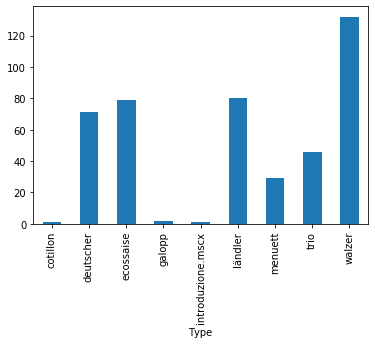

In [75]:
DANCES.groupby('Type').File.count().plot.bar();

In [77]:
def notes_bag(n):
    """Returns the relative duration of each tonal pitch class in the nth dance"""
    
    note_bag = pd.DataFrame()
    for i in Score(DANCES.File[n]).section_order:
        note_bag = pd.concat([note_bag, Score(DANCES.File[n]).get_notes(pitch_names = True).loc[i]], ignore_index = True)
    
    notes = pd.DataFrame(columns = ['duration'], index = ['C', 'C#', 'C##', 'Dbb', 'Db', 'D', 'D#', 'D##','Ebb', 'Eb', 'E','E#','E##', 'Fbb', 'Fb','F', 'F#','F##','Gbb', 'Gb', 'G', 'G#','G##', 'Abb', 'Ab', 'A', 'A#', 'A##', 'Bbb', 'Bb', 'B', 'B#','B##', 'Cbb','Cb'])

    temp = pd.DataFrame(note_bag.groupby('pitch_names')['duration'].sum()/note_bag.duration.sum())
    
    for note in temp.index:
        notes.loc[note] = temp.loc[note]
    
    #notes.columns = ['tonal_duration']
    
    #return temp.index
    return notes.applymap(float)

In [78]:
failed_parse = []
for i in DANCES.index:
    try:
         Score(DANCES.File[i])
    except:
        failed_parse.append(i)
        print(i)
        pass

4


26


42


49
50


66


70


75


118


147


161


184


187


214


ERROR:root:A startRepeat still needs closing.


218


ERROR:root:A startRepeat still needs closing.


221


224
225


237


239


ERROR:root:Correct up to firstMeasure
endRepeat
endRepeat
Next endRepeat invalid.
ERROR:root:Correct up to firstMeasure
endRepeat
endRepeat
Next endRepeat invalid.


262


267


285


293


ERROR:root:Correct up to firstMeasure
endRepeat
endRepeat
Next endRepeat invalid.


330


337


338


362


373


375


397


407


430


In [79]:
failed_parse

[4,
 26,
 42,
 49,
 50,
 66,
 70,
 75,
 118,
 147,
 161,
 184,
 187,
 214,
 218,
 221,
 224,
 225,
 237,
 239,
 262,
 267,
 285,
 293,
 330,
 337,
 338,
 362,
 373,
 375,
 397,
 407,
 430]

In [80]:
temp = []
for dance in DANCES.index:
    if dance in failed_parse:
        temp += [np.nan]
    else:
        notes = notes_bag(dance)
        temp += [float(scipy.stats.entropy(notes.dropna())/np.log(35))]
    
DANCES['entropy'] = temp

ERROR:root:Correct up to firstMeasure
endRepeat
endRepeat
Next endRepeat invalid.
ERROR:root:Correct up to firstMeasure
endRepeat
endRepeat
Next endRepeat invalid.
ERROR:root:Correct up to firstMeasure
endRepeat
endRepeat
Next endRepeat invalid.
ERROR:root:Correct up to firstMeasure
endRepeat
endRepeat
Next endRepeat invalid.
ERROR:root:Correct up to firstMeasure
endRepeat
endRepeat
Next endRepeat invalid.
ERROR:root:Correct up to firstMeasure
endRepeat
endRepeat
Next endRepeat invalid.
ERROR:root:Correct up to firstMeasure
endRepeat
endRepeat
Next endRepeat invalid.
ERROR:root:Correct up to firstMeasure
endRepeat
endRepeat
Next endRepeat invalid.
ERROR:root:Correct up to firstMeasure
endRepeat
endRepeat
Next endRepeat invalid.
ERROR:root:Correct up to firstMeasure
endRepeat
endRepeat
Next endRepeat invalid.
ERROR:root:Correct up to firstMeasure
endRepeat
endRepeat
Next endRepeat invalid.
ERROR:root:Correct up to firstMeasure
endRepeat
endRepeat
Next endRepeat invalid.


In [81]:
DANCES.head(10)

,File,Type,entropy
0,data/MuseScore_3/790/D790ländler07.mscx,ländler,0.573627
1,data/MuseScore_3/790/D790ländler11.mscx,ländler,0.655286
2,data/MuseScore_3/790/D790ländler10.mscx,ländler,0.587269
3,data/MuseScore_3/790/D790ländler06.mscx,ländler,0.605948
4,data/MuseScore_3/790/D790ländler01.mscx,ländler,NaN
5,data/MuseScore_3/790/D790ländler03.mscx,ländler,0.627634
6,data/MuseScore_3/790/D790ländler02.mscx,ländler,0.618343
7,data/MuseScore_3/790/D790ländler09.mscx,ländler,0.629897
8,data/MuseScore_3/790/D790ländler05.mscx,ländler,0.598099
9,data/MuseScore_3/790/D790ländler04.mscx,ländler,0.612313


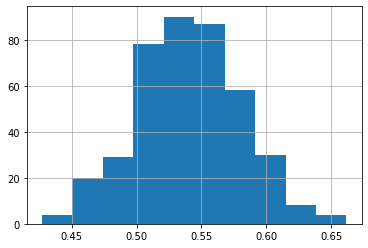

In [82]:
DANCES.entropy.hist();

In [83]:
DANCES.groupby('Type').entropy.mean()

Type
cotillon             0.563831
deutscher            0.544394
ecossaise            0.533044
galopp               0.557348
introduzione.mscx         NaN
ländler             0.531165
menuett              0.552381
trio                 0.522829
walzer               0.551595
Name: entropy, dtype: float64

In [85]:
def keysig(n):
    return Score(DANCES.File[n]).mc_info[0].keysig[0]

In [90]:
temp = []
for i in DANCES.index:
    if i in failed_parse:
        temp += [np.nan]
    else:
        temp += [keysig(i)]

DANCES['Keysig'] = temp

ERROR:root:Correct up to firstMeasure
endRepeat
endRepeat
Next endRepeat invalid.
ERROR:root:Correct up to firstMeasure
endRepeat
endRepeat
Next endRepeat invalid.
ERROR:root:Correct up to firstMeasure
endRepeat
endRepeat
Next endRepeat invalid.


In [101]:
scipy.stats.pearsonr(DANCES.dropna().entropy, DANCES.dropna().Keysig )

(0.0738146502715876, 0.1542517156746675)

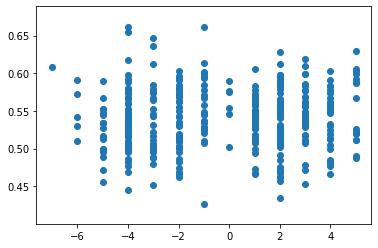

In [108]:
plt.scatter(DANCES.dropna().Keysig, DANCES.dropna().entropy);

In [ ]:
def KK(mode, transposition):
    """Krumhansl and Kessler (1982) key profiles for major and minor modes"""
    
    major = [6.20, 2.55, 3.45, 2.85, 4.22, 4.57, 2.67, 5.25, 2.45, 3.35, 2.70, 2.70]
    minor = [6.03, 3.35, 3.67, 5.28, 2.58, 3.55, 2.87, 4.80, 4.35, 2.67, 2.50, 3.42]
    
    #major = list(map(lambda x: x/sum(major), major))
    #minor = list(map(lambda x: x/sum(minor), minor))
    
    if mode == 0:
        return major[-transposition:]+major[:-transposition]
    elif mode == 1:
        return minor[-transposition:]+minor[:-transposition]
    else:
        print('0 = major, 1 = minor')